# How robust to random seeds?

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "runs/complexity_AZURE/hs_064_0306_205514"
out_dir = run_dir / "cell_states"

In [3]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

st_data_dir = Path("/home/tommy/spatio_temporal/data")
points = load_latlon_points(st_data_dir)
static = xr.open_dataset(st_data_dir / "camels_static.nc")

# Input / Target Data

In [4]:
from scripts.cell_state.normalize import normalize_cstate
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable


if not (data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc").exists():
    cn = xr.open_dataset(out_dir / "cell_states.nc")
    norm_cs_data = normalize_cstate(cn, variable_str="c_n")
    norm_cs_data["station_id"] = [int(sid) for sid in norm_cs_data["station_id"]]
    if "date" in norm_cs_data.dims:
        norm_cs_data = norm_cs_data.rename({"date": "time"})

    if isinstance(norm_cs_data, xr.DataArray):
        norm_cs_data = norm_cs_data.to_dataset()

    if "c_n" in [v for v in norm_cs_data.data_vars]:
        norm_cs_data = norm_cs_data.rename({"c_n": "cell_state"})
        
    norm_cs_data.to_netcdf(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")
    
else:
    norm_cs_data = xr.open_dataset(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")
 

cs = dataset_dimensions_to_variable(
    ds=norm_cs_data, 
    variable="c_n",
    dimension_to_convert_to_variable_dim="dimension",
)

In [5]:
from scripts.cell_state.normalize import normalize_2d_dataset

filepath = data_dir / "SOIL_MOISTURE/interp_full_timeseries_esa_cci_sm.nc"
esa_ds = xr.open_dataset(filepath).drop("spatial_ref")
if not isinstance(esa_ds, xr.Dataset):
    esa_ds = esa_ds.to_dataset()

for var in esa_ds.data_vars:
    esa_ds[var] = normalize_2d_dataset(esa_ds, variable_str=var, per_basin=True)

Normalising each station: 100%|██████████| 670/670 [00:00<00:00, 741.99it/s]


In [6]:
print(esa_ds.data_vars)

Data variables:
    sm               (station_id, time) float32 nan nan nan ... 0.539 -0.1536
    7_day_smooth_sm  (station_id, time) float32 nan nan nan ... -0.5138 -0.3665


# Imports

In [8]:
from scripts.cell_state.sklearn_models import (
    init_linear_model,
    evaluate,
    create_analysis_dataset,
)
from scripts.cell_state.timeseries_dataset import TimeSeriesDataset, get_time_basin_aligned_dictionary

In [12]:
target_ds = esa_ds
input_ds = cs

train_start_date: pd.Timestamp = pd.to_datetime("1998-01-01")
train_end_date: pd.Timestamp = pd.to_datetime("2006-09-30")
test_start_date: pd.Timestamp = pd.to_datetime("2006-10-01")
test_end_date: pd.Timestamp =  pd.to_datetime("2009-10-01")
seq_length = 1
basin_dim = "station_id"
time_dim = "time"
target_var = "7_day_smooth_sm"
input_variables = [f"dim{i}" for i in np.arange(64)]

# train test split
target_data = target_ds.sel(time=slice(train_start_date, train_end_date))
input_data = input_ds.sel(time=slice(train_start_date, train_end_date))

test_target_data = target_ds.sel(time=slice(test_start_date, test_end_date))
test_input_data = input_ds.sel(time=slice(test_start_date, test_end_date))

train_dataset = TimeSeriesDataset(
    input_data=input_data,
    target_data=target_data,
    target_variable=target_var,
    input_variables=input_variables,
    seq_length=seq_length,
    basin_dim=basin_dim,
    time_dim=time_dim,
    desc="Creating Train Samples",
)

train = get_time_basin_aligned_dictionary(train_dataset)

Extracting Data: 100%|██████████| 8335/8335 [01:04<00:00, 128.69it/s]


Merging and reshaping arrays


In [15]:
test_input_data = input_ds.sel(time=slice(test_start_date, test_end_date))
test_target_data = target_ds.sel(time=slice(test_start_date, test_end_date))

test_dataset = TimeSeriesDataset(
    input_data=test_input_data,
    target_data=test_target_data,
    target_variable=target_var,
    input_variables=input_variables,
    seq_length=seq_length,
    basin_dim=basin_dim,
    time_dim=time_dim,
    desc="Creating Test Samples",
)

test = get_time_basin_aligned_dictionary(test_dataset)

Extracting Data: 100%|██████████| 2145/2145 [00:16<00:00, 131.93it/s]


Merging and reshaping arrays


In [17]:
from typing import Dict, Tuple, Any

def fit_and_predict(train: Dict[str, np.ndarray], test: Dict[str, np.ndarray], random_seed: int = 100) -> Tuple[Any, xr.Dataset, xr.Dataset]:
    np.random.seed(random_seed)
    
    # intiialise and fit the model
    model = init_linear_model(kwargs={"verbose": 0})
    model.fit(train["X"], train["y"].ravel())

    # make predictions from the fitted model 
    preds, errors = evaluate(model, test)
    
    return model, preds, errors

In [19]:
from tqdm import tqdm
from collections import defaultdict

# initalise the model 
seeds = np.random.choice(np.arange(0, 1000), size=5, replace=False)
pbar = tqdm(seeds, desc="Training Random Seeds")

outputs = defaultdict(list)
for seed in pbar:
    pbar.set_postfix_str(f"Seed: {seed}")
    model, preds, errors = fit_and_predict(train, test, random_seed=seed)
    outputs["model"].append(model)
    outputs["preds"].append(preds)
    outputs["errors"].append(errors)


Training Random Seeds:   0%|          | 0/5 [00:00<?, ?it/s, Seed: 812]

-- Epoch 1
Norm: 0.63, NNZs: 38, Bias: -0.003981, T: 1920232, Avg. loss: 0.049703
Total training time: 1.58 seconds.
-- Epoch 2
Norm: 0.63, NNZs: 38, Bias: -0.004431, T: 3840464, Avg. loss: 0.049667
Total training time: 3.33 seconds.
-- Epoch 3
Norm: 0.63, NNZs: 37, Bias: -0.003784, T: 5760696, Avg. loss: 0.049664
Total training time: 5.05 seconds.
-- Epoch 4
Norm: 0.63, NNZs: 37, Bias: -0.010143, T: 7680928, Avg. loss: 0.049656
Total training time: 6.78 seconds.
Convergence after 4 epochs took 6.95 seconds




Calculating Errors:   0%|          | 0/668 [00:00<?, ?it/s]

Calculating Errors:   0%|          | 0/668 [00:00<?, ?it/s, 1001]

Calculating Errors:   0%|          | 0/668 [00:00<?, ?it/s, 2001]

Calculating Errors:   0%|          | 0/668 [00:00<?, ?it/s, 2002]

Calculating Errors:   0%|          | 0/668 [00:00<?, ?it/s, 3003]

Calculating Errors:   0%|          | 0/668 [00:00<?, ?it/s, 4001]

Calculating Errors:   0%|          | 0/668 [00:00<?, ?it/s, 4003]

Calculating Errors:   0%|          | 0/668 [00:00<?, ?it/s, 4005]

Calculating Errors:   0%|          | 0/668 [00:00<?, ?it/s, 4006]

Calculating Errors:   1%|          | 8/668 [00:00<00:08, 78.85it/s, 4006]

Calculating Errors:   1%|          | 8/668 [00:00<00:08, 78.85it/s, 5003]

Calculating Errors:   1%|          | 8/668 [00:00<00:08, 78.85it/s, 6007]

Calculating Errors:   1%|          | 8/668 [00:00<00:08, 78.85it/s, 6008]

Calculating Errors:   1%|          | 8/668 [00:00<00:08, 78.85it/s, 7001]

Calculating Errors:   1%| 

-- Epoch 1
Norm: 0.63, NNZs: 37, Bias: -0.007101, T: 1920232, Avg. loss: 0.049712
Total training time: 1.56 seconds.
-- Epoch 2
Norm: 0.63, NNZs: 38, Bias: -0.005232, T: 3840464, Avg. loss: 0.049672
Total training time: 3.31 seconds.
-- Epoch 3
Norm: 0.63, NNZs: 38, Bias: -0.006707, T: 5760696, Avg. loss: 0.049667
Total training time: 5.03 seconds.
-- Epoch 4
Norm: 0.63, NNZs: 36, Bias: -0.007086, T: 7680928, Avg. loss: 0.049670
Total training time: 6.74 seconds.
Convergence after 4 epochs took 6.91 seconds


Calculating Errors: 100%|██████████| 668/668 [00:08<00:00, 79.65it/s, 106001]

Training Random Seeds:  40%|████      | 2/5 [00:34<00:50, 16.96s/it, Seed: 44] 

-- Epoch 1
Norm: 0.63, NNZs: 37, Bias: 0.000500, T: 1920232, Avg. loss: 0.049692
Total training time: 1.57 seconds.
-- Epoch 2
Norm: 0.63, NNZs: 37, Bias: -0.006782, T: 3840464, Avg. loss: 0.049655
Total training time: 3.30 seconds.
-- Epoch 3
Norm: 0.63, NNZs: 36, Bias: -0.007152, T: 5760696, Avg. loss: 0.049649
Total training time: 5.02 seconds.
-- Epoch 4
Norm: 0.63, NNZs: 35, Bias: -0.010512, T: 7680928, Avg. loss: 0.049647
Total training time: 6.73 seconds.
Convergence after 4 epochs took 6.90 seconds


Calculating Errors: 100%|██████████| 668/668 [00:08<00:00, 80.28it/s, 106001]

Training Random Seeds:  60%|██████    | 3/5 [00:50<00:33, 16.74s/it, Seed: 407]

-- Epoch 1
Norm: 0.63, NNZs: 36, Bias: -0.003570, T: 1920232, Avg. loss: 0.049698
Total training time: 1.58 seconds.
-- Epoch 2
Norm: 0.63, NNZs: 36, Bias: -0.011551, T: 3840464, Avg. loss: 0.049659
Total training time: 3.31 seconds.
-- Epoch 3
Norm: 0.63, NNZs: 38, Bias: 0.000794, T: 5760696, Avg. loss: 0.049658
Total training time: 5.06 seconds.
-- Epoch 4
Norm: 0.63, NNZs: 37, Bias: -0.004906, T: 7680928, Avg. loss: 0.049654
Total training time: 6.78 seconds.
Convergence after 4 epochs took 6.95 seconds


Calculating Errors: 100%|██████████| 668/668 [00:08<00:00, 80.05it/s, 106001]

Training Random Seeds:  80%|████████  | 4/5 [01:07<00:16, 16.67s/it, Seed: 343]

-- Epoch 1
Norm: 0.63, NNZs: 37, Bias: -0.001811, T: 1920232, Avg. loss: 0.049683
Total training time: 1.59 seconds.
-- Epoch 2
Norm: 0.63, NNZs: 36, Bias: -0.005027, T: 3840464, Avg. loss: 0.049643
Total training time: 3.34 seconds.
-- Epoch 3
Norm: 0.63, NNZs: 38, Bias: -0.002622, T: 5760696, Avg. loss: 0.049643
Total training time: 5.07 seconds.
-- Epoch 4
Norm: 0.63, NNZs: 37, Bias: -0.002183, T: 7680928, Avg. loss: 0.049638
Total training time: 6.80 seconds.
Convergence after 4 epochs took 6.97 seconds


Calculating Errors: 100%|██████████| 668/668 [00:08<00:00, 79.93it/s, 106001]

Training Random Seeds: 100%|██████████| 5/5 [01:23<00:00, 16.74s/it, Seed: 343]


# Comparison Performance

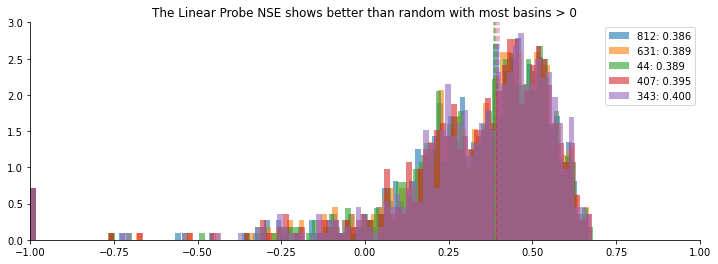

In [20]:
f, ax = plt.subplots(figsize=(12, 4))

for ix, errors in enumerate(outputs["errors"]):
    seed = seeds[ix]
    nse = errors["NSE"]

    ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{seed}: {nse.median().values:.3f}", alpha=0.6, color=f"C{ix}");
    ax.axvline(nse.median(), color=f"C{ix}", ls="--", alpha=0.5)
    

ax.set_xlim(-1, 1)
ax.legend()
ax.set_title("The Linear Probe NSE shows better than random with most basins > 0")
sns.despine()

# Plot the different weights

In [34]:
outputs["model"]

[SGDRegressor(alpha=0.01, early_stopping=True, loss='huber', n_iter_no_change=3,
              penalty='elasticnet', verbose=1),
 SGDRegressor(alpha=0.01, early_stopping=True, loss='huber', n_iter_no_change=3,
              penalty='elasticnet', verbose=1),
 SGDRegressor(alpha=0.01, early_stopping=True, loss='huber', n_iter_no_change=3,
              penalty='elasticnet', verbose=1),
 SGDRegressor(alpha=0.01, early_stopping=True, loss='huber', n_iter_no_change=3,
              penalty='elasticnet', verbose=1),
 SGDRegressor(alpha=0.01, early_stopping=True, loss='huber', n_iter_no_change=3,
              penalty='elasticnet', verbose=1)]

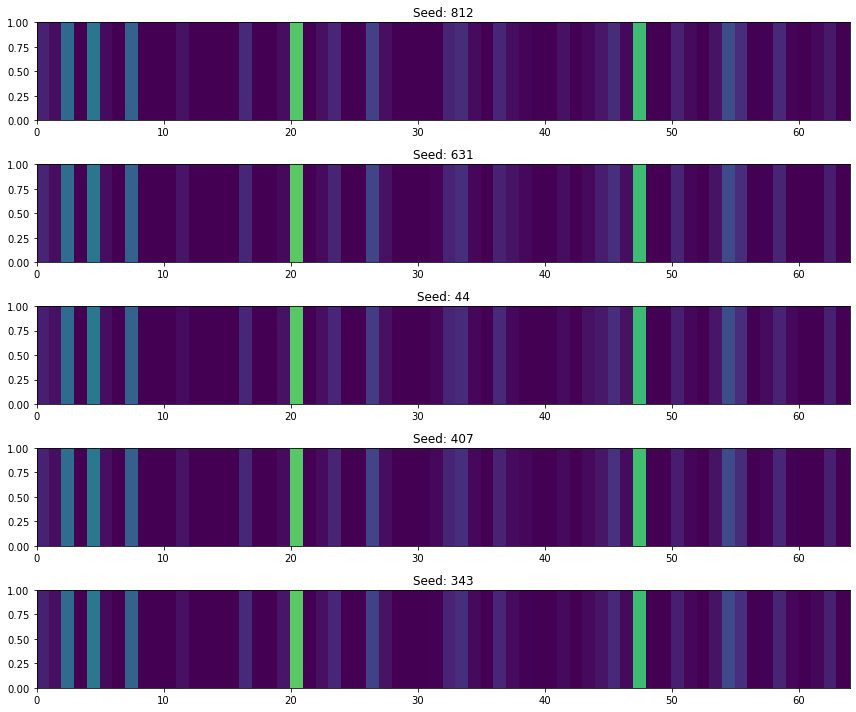

In [41]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

n_plots = len(outputs["model"])
f, axs = plt.subplots(n_plots, 1, figsize=(12, 2*n_plots))
for ix, model in enumerate(outputs["model"]):
    ax = axs[ix]
    seed = seeds[ix]
    w, b = get_model_weights(model)
    plot_weights(np.abs(w), kwargs={"vmin": 0.0, "vmax": 0.3}, ax=ax, cbar=False)
    ax.set_title(f"Seed: {seed}")
plt.tight_layout()